# ADA - Project Milestone 2: 
# *Analysis of speech behaviours between genders*

## Context

In this project, we are going to analyze data from Quotebank. Quotebank, as the name suggests, is an open corpus which gathers 178 million quotations from 2008 and 2020. Still, in this project, we will only focus on the most recent quotations, being from 2015 to 2020, accounting from a little over a million quotations.

We are interested in using this dataset to answer the following question: Do speech behaviours related to confidence and uncertainty vary between men and women?

To answer this question, we'll go through the following points:

1. To what extent can we observe the differences in communicative acts in relation to gender within a professional area? Are there noticeable differences between those professional areas?
3. What are the roles of nationality, culture/tradition (religion, ethnic groups), and education (whether the speaker obtained an academic degree) in determining those differences in speech between men and women? How are the lines drawn between the language we use and the environment around us?
4. Has there been a possible change over time (from 2015 to 2020)?

In order to have access to the speakers' information (e.g., speakers' genders), we use the open source data from wikidata (https://www.wikidata.org/wiki/Wikidata:Main_Page).

To analyse speech uncertainty, we adapted the public uncertainty detection classifier from the following paper "P. A. Jean, S. Harispe, S. Ranwez, P. Bellot, and J. Montmain, “[Uncertainty detection in natural language: A probabilistic model](https://www.researchgate.net/publication/303842922)” ACM Int. Conf. Proceeding Ser., vol. 13-15-June, no. June, 2016, doi: 10.1145/2912845.2912873".

## Table of contents

[1. Pre-processing of the data](#pre-processing) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Functions](#1functions)
- [Merging files from wikidata into one file containing the 9 million speakers](#1merging)
- [1.1 Loading and pre-processing of Quotebank data](#1.1)
- [1.2 Loading wikidata labels](#1.2) 
- [1.3 Pre-processing of wikidata](#1.3)
- [1.4 Exploratory Data Analysis of wikidata](#1.4)

[2. Creation of the lists of similar professions](#professions)

[3. Classification of the quotes](#classifier)

[4. Statistical-analysis](#analysis)

ADD POINT 5

## 1. Pre-processing of the data <a name="pre-processing"></a>

### Imports <a name="1imports"></a>

Let's start by importing our libraries. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Pathways <a name="1pathways"></a>

In order to run this project, you need to download the directories and files from the following drive: https://drive.google.com/drive/folders/1UgvnLUFhs14NDcZYH6NuZx2f_YC5i06N?usp=sharing. The data folders "Data" and "Data_parquet" need to be added in the same directory as this notebook. The two other directories ("Classifier" and "txt_files") will be needed in the [Classification of the quotes](#classifier).

In [2]:
# DATA_PATH contains all the quotes as well as the wikidata labels' descriptions
DATA_PATH = 'Data/'
# PATH_PARQUET contains all the data from wikidata
PATH_PARQUET = 'Data_parquet/'

### Functions <a name="1functions"></a>

The following functions are needed for the pre-processing.

In [3]:
def saving_wikidata(path):
    """
    Transforms all the wikidata files in one dataset saved as pickle. 
    This allows to load the file and use it more quickly and easily.
    Inputs:
        * path : pathway where to save the pickle file
    """
    wikidata_all = pd.DataFrame()
    for i in range(1,16):
        if i < 10:
            DATA_FILE = 'part-0000{}-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet'.format(i)
        else:
            DATA_FILE = 'part-000{}-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet'.format(i)
        wikidata = pd.read_parquet(PATH_PARQUET + DATA_FILE)
        wikidata_all = pd.concat([wikidata_all, wikidata])
    wikidata_all.to_pickle(path)

### Merging files from wikidata into one file containing the 9 million speakers <a name="1merging"></a>

Here, we create the file "all_wikidata.pck" containing all the raw data from wikidata. We already ran this cell and the file can be found in "Data". As this is a huge dataset, we save the file as pickle then read it, as this is much less comutationally costly than directly working with the data.

In [4]:
""" Only intented to be run once
saving_wikidata(DATA_PATH + "all_wikidata.pck")""";

### 1.1. Loading and pre-processing of Quotebank data <a name="1.1"></a>

The function `clean_quotebank` (in [Functions](#2functions) below) does a first cleaning of the quotebank dataset by living behind quotes from unknown speaker as they would not be useful towards our study. We chose to also drop the quotes from uncertain speakers, ie: where the speaker probability is bellow 0.5. As this is a computationally costly operation, the cleaning is performed at the same time we will create our quotebank sub dataframes in the [Creation of the lists of similar professions](#professions).

### 1.2 Loading wikidata labels <a name="1.2"></a>

Wikidata labels are encoded in items called QIDs, to map them back to human readable labels, we upload the following dataset.

In [4]:
qid_label = pd.read_csv(DATA_PATH+'wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

Let's have a quick look at this data frame.

In [5]:
qid_label.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


### 1.3 Pre-processing of wikidata <a name="1.3"></a>

To be able to find information about the speakers, we use wikidata. Let's start by creating a data frame of all the speakers from our pickle file "wikidata_all.pck".

In [ ]:
wikidata_all = pd.read_pickle("Data/wikidata_all.pck")
wikidata_all.shape

We now search for possible redundant speakers.

In [ ]:
wikidata_all['id'].is_unique

As this returns `True`, we can see that there are no duplicate speakers in wikidata. We'll now create a new dataframe (`cleaned_wikidata`).

In [ ]:
# Creation of a clean version of the data (without modifying the original one)
cleaned_wikidata = wikidata_all.copy(deep=True)

In [ ]:
cleaned_wikidata.head()

Now we want to remove rows where mandatory values for our study are missing like the name of the speaker and the gender.

In [ ]:
cleaned_wikidata = cleaned_wikidata[~cleaned_wikidata.label.isin([None, "None"])]
print(cleaned_wikidata.shape)
cleaned_wikidata = cleaned_wikidata[~cleaned_wikidata.gender.isin([None, "None"])]
print(cleaned_wikidata.shape)

### 1.4 Exploratory Data Analysis of wikidata <a name="1.4"></a>

In [ ]:
cleaned_wikidata['gender'] = cleaned_wikidata['gender'].apply(lambda x: x[0])
print("There are {} different unique genders in wikidata".format(cleaned_wikidata['gender'].unique().shape))
cleaned_wikidata['gender'].unique()


Let's observe their distribution:

In [ ]:
gender_dist = cleaned_wikidata.groupby('gender').size()
gender_dist = gender_dist.div(gender_dist.sum(axis=0), axis=0)
pl = gender_dist.plot(kind='bar', figsize=[7,5])
pl.set_title('Distribution of genders - log scale')
pl.set_ylabel('participants')
pl.set_xlabel('gender_dist')
pl.set_yscale('log')
plt.show()

In [ ]:
qid_label.loc[cleaned_wikidata['gender'].unique()]

In [ ]:
male_label = "Q6581097"
female_label= "Q6581072"

In [ ]:
gender_dist[(gender_dist.index != male_label) & (gender_dist.index != female_label)].sum()

We can see that less than 0.03% of the data is neither considered a male or a female. For simplicity in our study we will ignore those cases.

In [ ]:
cleaned_wikidata = cleaned_wikidata[cleaned_wikidata.gender.isin([male_label, female_label])]

In [ ]:
"""Only intented to be run once 
#Create occupation dataframe where everyone's occupation is known
occupation = cleaned_wikidata[~cleaned_wikidata['occupation'].isin([None])]
occupation.shape""";

In [ ]:
""" Only intented to be run once 
#Create complete datafram where occupation/religion/nationality/ethnic_group and academic_degree are known 
# for every speaker in the dataset
wiki_clean = occupation[~(occupation['religion'].isin([None, "None"]) & occupation['nationality'].isin([None, "None"]) &
                          occupation['ethnic_group'].isin([None, "None"]) & 
                          occupation['academic_degree'].isin([None, "None"]))]
wiki_clean.shape """;

In [ ]:
""" Only intented to be run once 
occupation.to_pickle(DATA_PATH + "occupation.pck")
wiki_clean.to_pickle(DATA_PATH + "wiki_clean.pck")"""

In [ ]:
""" Only intented to be run once  """
wiki_occupation = pd.read_pickle(DATA_PATH + "wiki_occupation.pck")
wiki_clean = pd.read_pickle("Data/wiki_clean.pck")

## 2.  Creation of the lists of similar professions <a name="professions"></a>

Now that all the pre-processing is done, we can start our analysis. 

First, we will focus on the initial matter, being to what extent we can observe the differences in communicative acts in relation to gender within a professional area and whether there noticeable differences between those professional areas.

### Functions <a name="2functions"></a>

In [6]:
def add_columns(column, target, init_df, name_column):
    """
    Checks if a target ('politician', 'male', 'female' etc...) is in a certain column.
    If it is, we return True in an additional column (name_column).
    Inputs:
        * column : name of column to search for target
        * target : item of interest 
        * init_df : initial data frame
        * name_column : name of new column of booleans
    Outputs:
        * final_df : dataframe with new column and only rows which contains the item
    """
    final_df = init_df.copy(deep = True)
    final_df[name_column] = final_df[column].apply(lambda x: np.any(x) in target)
    return final_df


def extracting_sub_df(quotebank, wikidata, column):
    """
    Creates a sub dataframe with information from quotebank and wikidata.
    We only take the rows in column which are True.
    Inputs:
        * quotebank : dataframe extracted from quotebank
        * wikidata : dataframe extracted from wikidata
        * column : column on which we base the merge
    Outputs :
        * sub_df : merged dataframe 
    """
    merged_df = pd.merge(quotebank, wikidata, left_on = 'speaker', right_on = 'label')
    merged_df['qids'] = merged_df['qids'].apply(lambda x : x[0])
    merged_df = merged_df[merged_df['qids'] == merged_df['id']]
    sub_df = merged_df[merged_df[column] == True]
    return sub_df


def clean_quotebank(df):
    """ 
    Cleans quotebank dataset by droping quotes from unknown speakers and
    quotes where the speaker is uncertain (p<0.5)
    Inputs:
        * df : quotebank dataframe to clean    
    """ 
    df_copy = df.copy(deep = True)
    df_copy = df_copy[~df_copy.speaker.isin(['None', None])]
    df_copy =  df_copy[df_copy['probas'].apply(lambda x: x[0][1]).values.astype(float) > 0.5]
    return df_copy 


def create_df_with_conditions(column, condition, wikidata, column_temp, start, stop):
    """
    From quotebank data, extracts and returns a data frame with only the rows that respect the condition.
    Inputs:
        * column : name of column where the condition is applied
        * condition : condition of interest 
        * wikidata : wiki database
        * column_temp : name of new column of booleans
    Outputs:
        * sub_df : dataframe with new column and only rows which contains the item
    """
    wiki_plus = add_columns(column, condition, wikidata, column_temp)
    sub_df = pd.DataFrame()
    # Milestone 2: (20,21) and (15,16) = only for 2020 quotes; Milestone 3: (15,21) = quotes from 2015 to 2020
    for i in range(start,stop):
        DATA_FILE = 'quotes-20{}.json.bz2'.format(i)
        with pd.read_json(DATA_PATH + DATA_FILE, lines = True, compression ='bz2', chunksize = 100000) as df_reader:
            for chunk in df_reader:
                sub_df = pd.concat([sub_df, extracting_sub_df(clean_quotebank(chunk), wiki_plus, column_temp)])
    sub_df = sub_df.drop(column_temp, axis = 1)
    return sub_df


def merging(quotebank, wikidata):
    """
    Creates a sub dataframe with information from quotebank and wikidata.
    We only take the rows in column which are True.
    Inputs:
        * quotebank : dataframe extracted from quotebank
        * wikidata : dataframe extracted from wikidata
        * column : column on which we base the merge
    Outputs :
        * sub_df : merged dataframe 
    """
    merged_df = pd.merge(quotebank, wikidata, left_on = 'speaker', right_on = 'label')
    merged_df['qids'] = merged_df['qids'].apply(lambda x : x[0])
    merged_df = merged_df[merged_df['qids'] == merged_df['id']]
    return merged_df


def create_df(wikidata, start, stop):
    """
    From quotebank data, extracts and returns a data frame with only the rows that respect the condition.
    Inputs:
        * column : name of column where the condition is applied
        * condition : condition of interest 
        * wikidata : wiki database
        * column_temp : name of new column of booleans
    Outputs:
        * sub_df : dataframe with new column and only rows which contains the item
    """
    sub_df = pd.DataFrame()
    # Milestone 2: (20,21) = only for 2020 quotes; Milestone 3: (15,21) = quotes from 2015 to 2020
    for i in range(start, stop):
        DATA_FILE = 'quotes-20{}.json.bz2'.format(i)
        with pd.read_json(DATA_PATH + DATA_FILE, lines = True, compression ='bz2', chunksize = 100000) as df_reader:
            for chunk in df_reader:
                sub_df = pd.concat([sub_df, merging(clean_quotebank(chunk), wikidata)])
    return sub_df

### 2.1 Creation of professional fields

Let's create data frames with different fields of professions to compare quotations of men and women without the bias of the professional background. To do that, we manually selected various fields such as arts, science, economy and politics with different professions listed. 

In [ ]:
art_professions = qid_label[qid_label['Label'].str.contains('cineast|painter|musician|sculpter|architect|philosoph|writer|actor|dancer', na=False)]
scientific_professions = qid_label[qid_label['Label'].str.contains('scientific|researcher|mathematician|doctor|astronomist|biologist|chemist|physicist|psychologist|sociologist|engineer|anatomist', na=False)]
economic_professions = qid_label[qid_label['Label'].str.contains('economist|banke|financ|CEO|CTO|chairman|auditor|stockbroker|insurer|business manager|retail merchandizer|pricing analyst|statistician|financial consultant|salesperson|risk analyst|Data analyst|accountant|economic researcher|Investm|actuary', na=False)]
political_professions = qid_label[qid_label['Label'].str.contains('politician|president|minister|government', na=False)]
# Printing 
'''
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(economic_professions)
''';

### 2.2 Creation of sub-dataframes per professions

We now want to combine the information of the speakers from wikidata with our professional fields to create data frames of specific speakers' professions.

First, we create data frames for year 2020.

In [ ]:
""" Only intented to be run once 
df_politicians_2020 = create_df_with_conditions('occupation', political_professions.index, wiki_occupation, 'ispolitician', 20, 21)
df_artists_2020 = create_df_with_conditions('occupation', art_professions.index, wiki_occupation, 'isartist', 20, 21)
df_scientists_2020 = create_df_with_conditions('occupation', scientific_professions.index, wiki_occupation, 'isscientist', 20, 21)
df_economists_2020 = create_df_with_conditions('occupation', economic_professions.index, wiki_occupation, 'iseconomist', 20, 21)""";

Second, we create data frames for year 2015.

In [ ]:
""" Only intented to be run once """
df_politicians_2015 = create_df_with_conditions('occupation', political_professions.index, wiki_occupation, 'ispolitician', 15, 16)
df_artists_2015 = create_df_with_conditions('occupation', art_professions.index, wiki_occupation, 'isartist', 15, 16)
df_scientists_2015 = create_df_with_conditions('occupation', scientific_professions.index, wiki_occupation, 'isscientist', 15, 16)
df_economists_2015 = create_df_with_conditions('occupation', economic_professions.index, wiki_occupation, 'iseconomist', 15, 16)

We now generate pickle files where we store all the quotations of both genders with the same professional field.

In [ ]:
""" Only intented to be run once
df_politicians_2020.to_pickle(DATA_PATH + "politicians_2020.pck")
df_artists_2020.to_pickle(DATA_PATH + "artists_2020.pck")
df_scientists_2020.to_pickle(DATA_PATH + "scientists_2020.pck")
df_economists_2020.to_pickle(DATA_PATH + "economists_2020.pck")""";
df_politicians_2015.to_pickle(DATA_PATH + "politicians_2015.pck")
df_artists_2015.to_pickle(DATA_PATH + "artists_2015.pck")
df_scientists_2015.to_pickle(DATA_PATH + "scientists_2015.pck")
df_economists_2015.to_pickle(DATA_PATH + "economists_2015.pck")

### 2.3 Saving of all sub data frames useful for processing

Once we generated the pickle files, we can use them with the classifier.

In [ ]:
df_politicians_2020 = pd.read_pickle(DATA_PATH + "politicians_2020.pck")
df_artists_2020 = pd.read_pickle(DATA_PATH + "artists_2020.pck")
df_scientists_2020 = pd.read_pickle(DATA_PATH + "scientists_2020.pck")
df_economists_2020 = pd.read_pickle(DATA_PATH + "economists_2020.pck")
df_politicians_2015 = pd.read_pickle(DATA_PATH + "politicians_2015.pck")
df_artists_2015 = pd.read_pickle(DATA_PATH + "artists_2015.pck")
df_scientists_2015 = pd.read_pickle(DATA_PATH + "scientists_2015.pck")
df_economists_2015 = pd.read_pickle(DATA_PATH + "economists_2015.pck")

### 2.4 Creation of sub data frame without conditions

In [ ]:
""" Only intented to be run once
df_without_conditions_2020 = create_df(wiki_clean, 20, 21)
df_without_conditions_2020.to_pickle(DATA_PATH + "df_without_conditions_2020.pck")"""

In [13]:
df_without_conditions_2020 = pd.read_pickle(DATA_PATH + "backgrounds_2020.pck")

We take a random sample of our dataframe to analyze the language distribution. It was not possible to translate more than 300 rows at a time using googletrans library. We consider that this sample selected randomly is representative of the whole dataset.

In [14]:
seed = 2
small_df = df_without_conditions_2020.sample(n=300, random_state=seed)

In [15]:
print(small_df.shape)
small_df.head(3)

(300, 24)


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,aliases,...,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
65382,2020-01-16-037739,I will seek to mend fences with our neighbouri...,John Campion,Q24572630,2020-01-16 06:01:00,1,"[[John Campion, 0.6249], [None, 0.3751]]",[http://www.shropshirestar.com/news/crime/2020...,E,[John-Paul Campion],...,None,None,[Q82955],[Q9626],None,Q24572630,John Campion,None,item,None
27097,2020-02-13-119432,"We're training at Aston Villa again, mid journ...",Chris Beech,Q5105871,2020-02-13 17:27:16,1,"[[Chris Beech, 0.6725], [None, 0.238], [Dean S...",[https://www.birminghammail.co.uk/sport/footba...,E,None,...,None,None,[Q937857],None,None,Q5105871,Chris Beech,None,item,None
25289,2020-01-23-019530,Exports of firearms and related items that do ...,R. Clarke Cooper,Q7273550,2020-01-23 22:15:25,1,"[[R. Clarke Cooper, 0.8201], [None, 0.1799]]",[https://www.cnbc.com/2020/01/23/gun-exports-g...,E,[René Clarke Cooper],...,None,None,"[Q11986654, Q189290, Q82955]",[Q29468],None,Q7273550,R. Clarke Cooper,None,item,[Q682443]


In [9]:
#We use textblob to identify quotations language
from googletrans import Translator
translator = Translator()
small_df['quote_language'] = small_df['quotation'].apply(lambda x: translator.translate(x).src)

In [10]:
small_df['quote_language'].unique()

array(['en', 'fr', 'ms', 'sw'], dtype=object)

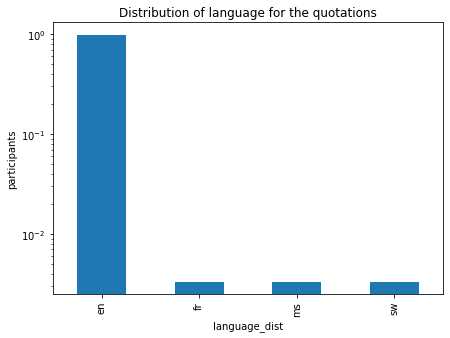

In [12]:
language_dist = small_df.groupby('quote_language').size()
language_dist = language_dist.div(language_dist.sum(axis=0), axis=0)
pl = language_dist.plot(kind='bar', figsize=[7,5])
pl.set_title('Distribution of language for the quotations in log scale')
pl.set_ylabel('participants')
pl.set_xlabel('language_dist')
pl.set_yscale('log')
plt.show()


We observe that the dataset is composed in vast majority of english quotes (99%) but it also contains quotes coming from different languages like french, malaysian and swahili.

## 3. Classification of the quotes <a name="classifier"></a>

To distinguish between uncertain and certain quotations, we use the uncertainty detection classifier from the following paper "P. A. Jean, S. Harispe, S. Ranwez, P. Bellot, and J. Montmain, “[Uncertainty detection in natural language: A probabilistic model](https://www.researchgate.net/publication/303842922)” ACM Int. Conf. Proceeding Ser., vol. 13-15-June, no. June, 2016, doi: 10.1145/2912845.2912873". 

It's public git repository is: https://github.com/PAJEAN/uncertaintyDetection

Still, as it was created 6 years ago, it only runs on python2. As we are using python3, we modified it to run for our project. We describe below how to run it.

This uncertainty detection classifier is based on a very synthetic vector representation of sentences. Each dimension of this vector encrypts the main features of this sentence (e.g. uni-gram, bi-gram). The representation of the classifier is directly inspired by binary classification methods and returns only the uncertain quotations.

### Pathways

As already mentionned in the [Pre-processing of the data](#pre-processing), the data folder "txt_files" must be downloaded and added in the same directory as this notebook.

In [10]:
PATH_TXT = 'txt_files/'

### Functions

In [11]:
def quotes_to_txt(file_name, df):
    """
    Changes quotes dataframe to a text file 
    Inputs:
        * file_name : text name
        * quotes : dataframe to convert
    """
    quotes = df.quotation.astype(str)
    with open(file_name, "w", encoding = "utf-8") as f:
        for ind, quote in enumerate(quotes):
            f.write(str(ind) + " " + quote + "\n")
    f.close()

### 3.1 Creation of the text files

To be able to run the classifier, we first need to create txt files with all the quotes and their index for each professional field. We already ran this cell and the files can be found in "txt_files".

In [ ]:
""" Only intented to be run once
quotes_to_txt(PATH_TXT + "politicians_2020.txt", df_politicians_2020)
quotes_to_txt(PATH_TXT + "artists_2020.txt", df_artists_2020)
quotes_to_txt(PATH_TXT + "scientists_2020.txt", df_scientists_2020)
quotes_to_txt(PATH_TXT + "economists_2020.txt", df_economists_2020)
quotes_to_txt(PATH_TXT + "df_without_conditions_2020.txt", df_without_conditions_2020)
""";
quotes_to_txt(PATH_TXT + "politicians_2015.txt", df_politicians_2015)
quotes_to_txt(PATH_TXT + "artists_2015.txt", df_artists_2015)
quotes_to_txt(PATH_TXT + "scientists_2015.txt", df_scientists_2015)
quotes_to_txt(PATH_TXT + "economists_2015.txt", df_economists_2015)

### 3.2 Use of the uncertainty detection classifier

After creating the files, we need to use the classifier to separate the uncertain and certain quotes. To continue, you must have downloaded the "Classifier" directory (see the [Pre-processing of the data](#pre-processing)) and add its files to the Classifier folder of the github repository.

### **How to run the classifier**

To be able to run the file MUD.py, you will need in your ADA environment: 
* Python 3.8
* nltk library
* numpy library
* sklearn library

Once you have downloaded and installed all the libraries in your envrionment, you're good to go.  

To run the program, you have to open a terminal on jupyter notebook or an anaconda prompt on anaconda. You have to go in the project repository (in the main folder) and run the following command : **python MUD.py sfu Classifier/Input/name_of_the_file.txt**

It is really important that you have the **ADA environment activated** to run this line.   

The following files are the ones that you can put in the classifier (instead of name_of_the_file) :
* politicians.txt
* artists.txt
* scientists.txt
* economists.txt
* df_without_conditions_2020.txt

### **What does it returns ?**

The classifier will run for approximately 10 to 20 min depending on the file you give him. Once it is finished, you can find in the Data/Results folder two files, ***certainty_sentences*** and ***uncertainty_sentences***.  
The file ***certainty_sentences*** : it is a txt file with all the quotes that have been considered as "certain" by the classifier; the file ***uncertainty_sentences*** is a txt file with all the quotes that have been considered as "uncertain" by the classifier.  

You can find all these files under other names in function of the professions in the txt_files folder : 
* politicians_uncertainty.txt
* artists_uncertainty.txt
* scientists_uncertainty.txt
* economists_uncertainty.txt
* df_without_conditions_2020.txt

In the next section, we will load those files and start the statistical analysis.

## 4. Statistical analysis <a name="analysis"></a>

### Functions

In [8]:
def extract_lines(txt_file):
    """
    Extracts the lines from a text file.
    Inputs:
        * txt_file : text file
    Outputs:
        * lines : all lines from text file
    """
    lines = []
    with open(txt_file, "r", encoding = "utf8") as file:
        for line in file:
            lines.append(line) 
    return lines


def extract_indices(lines):
    """
    Extracts the indices from every line.
    Inputs:
        * lines : all lines from text file
    Outputs:
        * indices : the indices from each lines
    """
    indices = []
    for i in range(0,len(lines)):
        index = ''
        line = lines[i]
        for j in range(0,len(line)):
            char = line[j]
            if char.isspace():
                break
            else:
                index += char
        indices.append(index)
    return indices


def create_df_from_txt(txt_file, df_profession):
    """
    Creates a sub data frame from df_profession containing the rows defined in the txt_file.
    Inputs:
        * txt_file : text file
        * df_profession : data frame containing all the quotes from a professional field
    Outputs:
        * df_uncertain_profession : dataframe containing the uncertain quotes from this professional field
    """
    df_uncertain_profession = df_profession.iloc[extract_indices(extract_lines(txt_file))]
    return df_uncertain_profession


def create_gender_dist(df_profession, df_uncertain_profession):
    """
    Computes the gender distribution of uncertain speakers for a certain profession.
    Inputs:
        * df_profession : data frame containing all the quotes from a professional field
        * df_uncertain_profession : dataframe containing the uncertain quotes from this professional field
    Outputs:
        * gender_dist : the gender distribution of uncertain speakers for a certain profession in percentage
    """
    gender_dist = df_uncertain_profession.groupby('gender').size()/df_profession.groupby('gender').size() * 100
    return gender_dist


def plot_hist(df, profession):
    ax = df.plot(kind='bar')
    labels = qid_label.loc[df.index]['Label'].values
    ax.set_ylabel('% of {}'.format(profession))
    ax.set_xticklabels(labels)
    plt.title('Relative percentage of uncertain {a}  within a gender'.format(a=profession,b=profession), pad=20)

### 4.1 Creation of the uncertain and certain dataframes

In [ ]:
#2020
df_uncertain_politicians_2020 = create_df_from_txt(PATH_TXT + "politicians_uncertainty_2020.txt", df_politicians_2020)
df_uncertain_artists_2020 = create_df_from_txt(PATH_TXT + "artists_uncertainty_2020.txt", df_artists_2020)
df_uncertain_scientists_2020 = create_df_from_txt(PATH_TXT + "scientists_uncertainty_2020.txt", df_scientists_2020)
df_uncertain_economists_2020 = create_df_from_txt(PATH_TXT + "economists_uncertainty_2020.txt", df_economists_2020)
#2015
df_uncertain_politicians_2015 = create_df_from_txt(PATH_TXT + "politicians_uncertainty_2015.txt", df_politicians_2015)
df_uncertain_artists_2015 = create_df_from_txt(PATH_TXT + "artists_uncertainty_2015.txt", df_artists_2015)
df_uncertain_scientists_2015 = create_df_from_txt(PATH_TXT + "scientists_uncertainty_2015.txt", df_scientists_2015)
df_uncertain_economists_2015 = create_df_from_txt(PATH_TXT + "economists_uncertainty_2015.txt", df_economists_2015)

In [ ]:
#2020
df_certain_politicians_2020 = df_politicians_2020[~df_politicians_2020.quoteID.isin(df_uncertain_politicians_2020.quoteID)]
df_certain_artists_2020 = df_artists_2020[~df_artists_2020.quoteID.isin(df_uncertain_artists_2020.quoteID)]
df_certain_scientists_2020 = df_scientists_2020[~df_scientists_2020.quoteID.isin(df_uncertain_scientists_2020.quoteID)]
df_certain_economists_2020 = df_economists_2020[~df_economists_2020.quoteID.isin(df_uncertain_economists_2020.quoteID)]
#2015
df_certain_politicians_2015 = df_politicians_2015[~df_politicians_2015.quoteID.isin(df_uncertain_politicians_2015.quoteID)]
df_certain_artists_2015 = df_artists_2015[~df_artists_2015.quoteID.isin(df_uncertain_artists_2015.quoteID)]
df_certain_scientists_2015 = df_scientists_2015[~df_scientists_2015.quoteID.isin(df_uncertain_scientists_2015.quoteID)]
df_certain_economists_2015 = df_economists_2015[~df_economists_2015.quoteID.isin(df_uncertain_economists_2015.quoteID)]

### 4.2 Analysis of the gender distribution

In [ ]:
#2020
politicians_gender_dist_2020 = create_gender_dist(df_politicians_2020, df_uncertain_politicians_2020)
economists_gender_dist_2020 = create_gender_dist(df_economists_2020, df_uncertain_economists_2020)
artists_gender_dist_2020 = create_gender_dist(df_artists_2020, df_uncertain_artists_2020)
scientists_gender_dist_2020 = create_gender_dist(df_scientists_2020, df_uncertain_scientists_2020)

#2015
politicians_gender_dist_2015 = create_gender_dist(df_politicians_2015, df_uncertain_politicians_2015)
economists_gender_dist_2015 = create_gender_dist(df_economists_2015, df_uncertain_economists_2015)
artists_gender_dist_2015 = create_gender_dist(df_artists_2015, df_uncertain_artists_2015)
scientists_gender_dist_2015 = create_gender_dist(df_scientists_2015, df_uncertain_scientists_2015)

In [ ]:
plt.figure(figsize=(17,4))

plt.subplot(1,4,1)
plot_hist(politicians_gender_dist_2020, 'politician')
plt.subplot(1,4,2)
plot_hist(artists_gender_dist_2020, 'artist')
plt.subplot(1,4,3)
plot_hist(scientists_gender_dist_2020, 'scientist')
plt.subplot(1,4,4)
plot_hist(economists_gender_dist_2020, 'economist')

plt.show()

### 4.3 Background influence

Let's have a look at our second question which investigates the roles culture, education and traditions play in determining those differences in speech between men and women.

In [16]:
df_uncertain_no_conditions_2020 = create_df_from_txt(PATH_TXT + "uncertainty_df_without_conditions_2020.txt", df_without_conditions_2020)

Let's first have a look at our features and which could relate to culture, education or tradition.

In [17]:
df_uncertain_no_conditions_2020.columns

Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase', 'aliases', 'date_of_birth', 'nationality',
       'gender', 'lastrevid', 'ethnic_group', 'US_congress_bio_ID',
       'occupation', 'party', 'academic_degree', 'id', 'label', 'candidacy',
       'type', 'religion'],
      dtype='object')

We see that `nationality`, `ethnic_group` and `religion` could give cultural and traditional background information on the speaker.  
While `academic_degree` can give information on the educational aspect of the quotation author.

#### Cultural background influence 

Let's define the function which allows to plot the labels of each cultural and educationnal category with respect to gender:

In [18]:
influences = ['nationality', 'religion','ethnic_group', 'academic_degree']

In [19]:
def plot_influence(df, name_influence):
    df[name_influence] = qid_label.loc[df[name_influence]].Label.values
    occur = df.groupby(name_influence)[name_influence].agg('count').sort_values(ascending=False).head(20)
    df = df[df[name_influence].isin(occur.index)]
    fem = df[df['gender'] == 'Q6581072']
    mal = df[df['gender'] == 'Q6581097']
    df = pd.concat([fem[name_influence].value_counts(normalize=True), mal[name_influence].value_counts(normalize=True)], axis=1, sort=True)
    df.columns = ["Women", "Men"]
    df.plot(kind='bar', figsize=(20,5))
    plt.ylabel('Normalised count')
    plt.xticks(rotation=45, ha="right")
    plt.title('Number of uncertain quotations in function of {} and gender'.format(name_influence))
    plt.show()

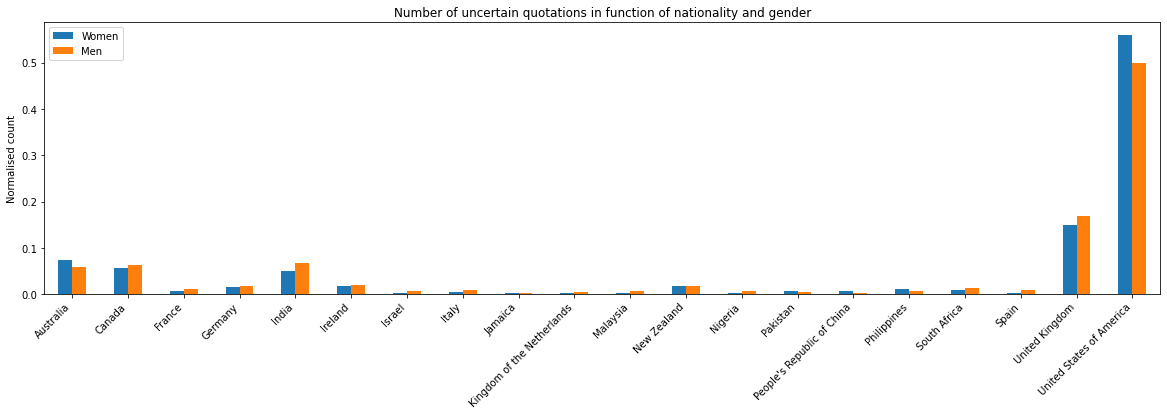

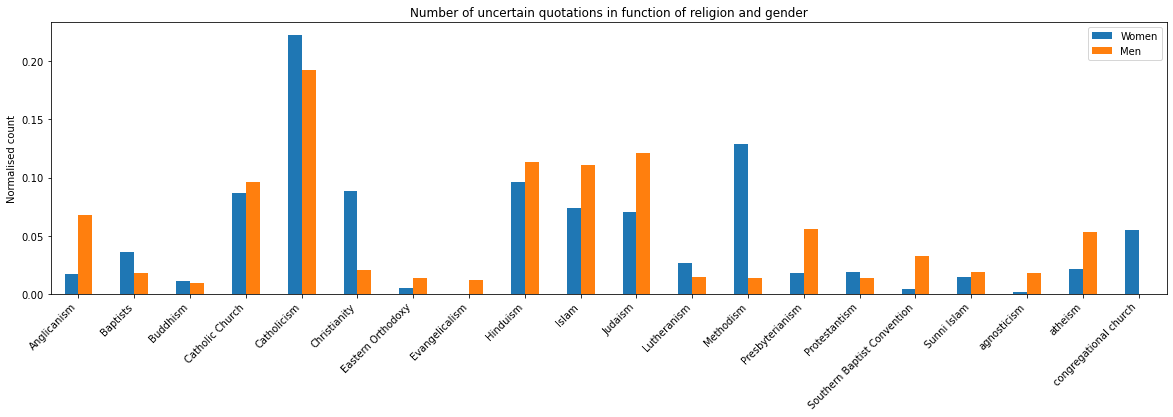

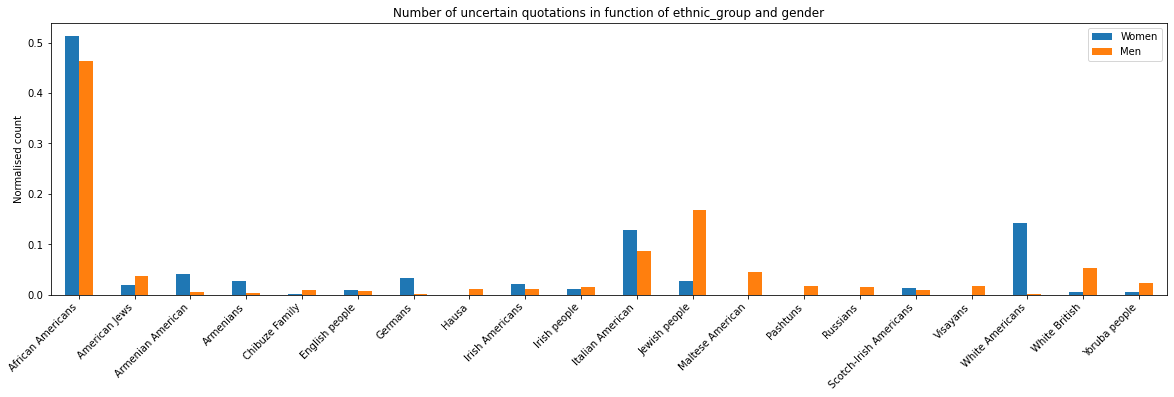

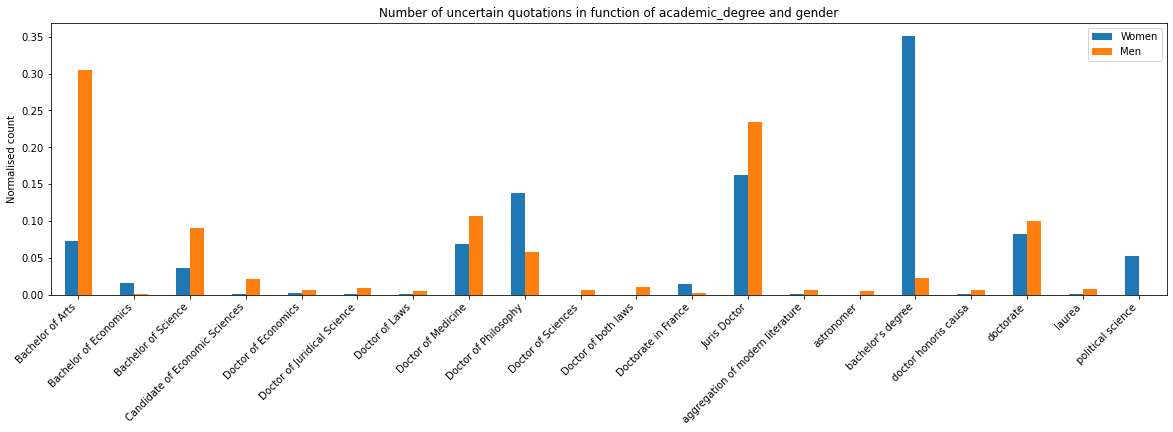

In [20]:
for influence in influences:
    working_df = df_uncertain_no_conditions_2020.copy(deep=True)
    working_df = working_df[~working_df[influence].isin([None, "None"])]
    working_df[influence] = working_df[influence].apply(lambda x: x[0])
    plot_influence(working_df, influence)